#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                                'python-git-workspace', 'PhotoForceReconML', 'image_data', 'val')
train_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'train')
val_label_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'val')
models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [ ]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/data_loader.py'

In [3]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_label_path, str(i), 'angles_inner.npy'))
    y_val[i] = np.load(os.path.join(val_label_path, str(i), 'angles_inner.npy'))

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGeneratorTrain(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGeneratorTrain(X_val[i], y_val[i], **params) 

#### VGG19 Models Building

Convolutional neural networks is defined and compiled in this step.

In [7]:
base_model = {}

# Load VGG19 model to be the base model
for k in range(5):
    i = k + 2
    base_model[i] = applications.VGG19(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model[i].trainable = False

In [8]:
# Define the model
model = {}
for k in range(5):
    i = k + 2
    inputs = Input(shape=(128, 128, 3))
    x = base_model[i](inputs, training = False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(i, activation='linear')(x)
    model[i] = Model(inputs, outputs)

In [9]:
for k in range(5):
    i = k + 2
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 8,391,682
Non-trainable params: 20,024,384
_________________________________________

#### VGG19 Model Training

The model is trained using Adam optimizer. The loss is defined to be mean absolute error. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 30 epochs. 

In [10]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(models_path, 'vgg19_angles_inner_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [12]:
epochs = 200
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.6630 - mean_absolute_error: 0.6630
Epoch 00001: val_loss improved from inf to 0.46982, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_2.h5
500/500 [==============================] - 48s 95ms/step - loss: 0.6630 - mean_absolute_error: 0.6630 - val_loss: 0.4698 - val_mean_absolute_error: 0.4698
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 0.4901 - mean_absolute_error: 0.4901
Epoch 00002: val_loss improved from 0.46982 to 0.20727, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_2.h5
500/500 [==============================] - 42s 84ms/step - loss: 0.4901 - mean_absolute_error: 0.4901 - val_loss: 0.2073 - val_mean_absolute_error: 0.2073
Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 0.4605 - mean_absolute_error: 0.4605
Epoch 00003: val_lo

Epoch 24/200
500/500 [==============================] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2162
Epoch 00024: val_loss did not improve from 0.09474
500/500 [==============================] - 41s 81ms/step - loss: 0.2162 - mean_absolute_error: 0.2162 - val_loss: 0.1333 - val_mean_absolute_error: 0.1333
Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.2108 - mean_absolute_error: 0.2108
Epoch 00025: val_loss did not improve from 0.09474
500/500 [==============================] - 40s 80ms/step - loss: 0.2108 - mean_absolute_error: 0.2108 - val_loss: 0.1036 - val_mean_absolute_error: 0.1036
Epoch 26/200
500/500 [==============================] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2145
Epoch 00026: val_loss did not improve from 0.09474
500/500 [==============================] - 41s 81ms/step - loss: 0.2145 - mean_absolute_error: 0.2145 - val_loss: 0.1387 - val_mean_absolute_error: 0.1387
Epoch 27/200
500/500 [==============================] -

Epoch 50/200
500/500 [==============================] - ETA: 0s - loss: 0.2119 - mean_absolute_error: 0.2119
Epoch 00050: val_loss did not improve from 0.08992
500/500 [==============================] - 41s 83ms/step - loss: 0.2119 - mean_absolute_error: 0.2119 - val_loss: 0.1068 - val_mean_absolute_error: 0.1068
Epoch 51/200
500/500 [==============================] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2166
Epoch 00051: val_loss did not improve from 0.08992
500/500 [==============================] - 39s 78ms/step - loss: 0.2166 - mean_absolute_error: 0.2166 - val_loss: 0.1091 - val_mean_absolute_error: 0.1091
Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2122
Epoch 00052: val_loss did not improve from 0.08992
500/500 [==============================] - 40s 80ms/step - loss: 0.2122 - mean_absolute_error: 0.2122 - val_loss: 0.1188 - val_mean_absolute_error: 0.1188
Epoch 00052: early stopping
Model for  3  angles
Epoch 

Epoch 21/200
500/500 [==============================] - ETA: 0s - loss: 0.2465 - mean_absolute_error: 0.2465
Epoch 00021: val_loss improved from 0.17304 to 0.16637, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_3.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.2465 - mean_absolute_error: 0.2465 - val_loss: 0.1664 - val_mean_absolute_error: 0.1664
Epoch 22/200
500/500 [==============================] - ETA: 0s - loss: 0.2408 - mean_absolute_error: 0.2408
Epoch 00022: val_loss did not improve from 0.16637
500/500 [==============================] - 40s 80ms/step - loss: 0.2408 - mean_absolute_error: 0.2408 - val_loss: 0.2044 - val_mean_absolute_error: 0.2044
Epoch 23/200
500/500 [==============================] - ETA: 0s - loss: 0.2409 - mean_absolute_error: 0.2409
Epoch 00023: val_loss did not improve from 0.16637
500/500 [==============================] - 41s 82ms/step - loss: 0.2409 - mean_absolute_error: 0

500/500 [==============================] - 41s 82ms/step - loss: 0.2257 - mean_absolute_error: 0.2257 - val_loss: 0.1504 - val_mean_absolute_error: 0.1504
Epoch 46/200
500/500 [==============================] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.2264
Epoch 00046: val_loss did not improve from 0.15043
500/500 [==============================] - 40s 80ms/step - loss: 0.2264 - mean_absolute_error: 0.2264 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967
Epoch 47/200
500/500 [==============================] - ETA: 0s - loss: 0.2290 - mean_absolute_error: 0.2290
Epoch 00047: val_loss did not improve from 0.15043
500/500 [==============================] - 40s 80ms/step - loss: 0.2290 - mean_absolute_error: 0.2290 - val_loss: 0.1510 - val_mean_absolute_error: 0.1510
Epoch 48/200
500/500 [==============================] - ETA: 0s - loss: 0.2270 - mean_absolute_error: 0.2270
Epoch 00048: val_loss improved from 0.15043 to 0.14412, saving model to /home/renat_sergazinov/python-git-

Epoch 71/200
500/500 [==============================] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2185
Epoch 00071: val_loss did not improve from 0.13869
500/500 [==============================] - 41s 81ms/step - loss: 0.2185 - mean_absolute_error: 0.2185 - val_loss: 0.1535 - val_mean_absolute_error: 0.1535
Epoch 72/200
500/500 [==============================] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2184
Epoch 00072: val_loss did not improve from 0.13869
500/500 [==============================] - 40s 81ms/step - loss: 0.2184 - mean_absolute_error: 0.2184 - val_loss: 0.1493 - val_mean_absolute_error: 0.1493
Epoch 73/200
500/500 [==============================] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2171
Epoch 00073: val_loss did not improve from 0.13869
500/500 [==============================] - 40s 80ms/step - loss: 0.2171 - mean_absolute_error: 0.2171 - val_loss: 0.1605 - val_mean_absolute_error: 0.1605
Epoch 74/200
499/500 [============================>.] -

Epoch 4/200
500/500 [==============================] - ETA: 0s - loss: 0.4678 - mean_absolute_error: 0.4678
Epoch 00004: val_loss did not improve from 0.24678
500/500 [==============================] - 41s 81ms/step - loss: 0.4678 - mean_absolute_error: 0.4678 - val_loss: 0.2574 - val_mean_absolute_error: 0.2574
Epoch 5/200
500/500 [==============================] - ETA: 0s - loss: 0.4495 - mean_absolute_error: 0.4495
Epoch 00005: val_loss did not improve from 0.24678
500/500 [==============================] - 42s 83ms/step - loss: 0.4495 - mean_absolute_error: 0.4495 - val_loss: 0.3167 - val_mean_absolute_error: 0.3167
Epoch 6/200
500/500 [==============================] - ETA: 0s - loss: 0.4346 - mean_absolute_error: 0.4346
Epoch 00006: val_loss improved from 0.24678 to 0.23503, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_4.h5
500/500 [==============================] - 40s 80ms/step - loss: 0.4346 - mean_absolute_error: 0.43

Epoch 51/200
500/500 [==============================] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2129
Epoch 00051: val_loss did not improve from 0.15070
500/500 [==============================] - 40s 80ms/step - loss: 0.2129 - mean_absolute_error: 0.2129 - val_loss: 0.1687 - val_mean_absolute_error: 0.1687
Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2133
Epoch 00052: val_loss did not improve from 0.15070
500/500 [==============================] - 41s 81ms/step - loss: 0.2133 - mean_absolute_error: 0.2133 - val_loss: 0.1739 - val_mean_absolute_error: 0.1739
Epoch 53/200
500/500 [==============================] - ETA: 0s - loss: 0.2114 - mean_absolute_error: 0.2114
Epoch 00053: val_loss did not improve from 0.15070
500/500 [==============================] - 40s 81ms/step - loss: 0.2114 - mean_absolute_error: 0.2114 - val_loss: 0.1613 - val_mean_absolute_error: 0.1613
Epoch 54/200
499/500 [============================>.] -

Epoch 9/200
499/500 [============================>.] - ETA: 0s - loss: 0.3864 - mean_absolute_error: 0.3864
Epoch 00009: val_loss improved from 0.23602 to 0.23217, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_5.h5
500/500 [==============================] - 41s 81ms/step - loss: 0.3865 - mean_absolute_error: 0.3865 - val_loss: 0.2322 - val_mean_absolute_error: 0.2322
Epoch 10/200
500/500 [==============================] - ETA: 0s - loss: 0.3649 - mean_absolute_error: 0.3649
Epoch 00010: val_loss did not improve from 0.23217
500/500 [==============================] - 41s 81ms/step - loss: 0.3649 - mean_absolute_error: 0.3649 - val_loss: 0.2462 - val_mean_absolute_error: 0.2462
Epoch 11/200
500/500 [==============================] - ETA: 0s - loss: 0.3539 - mean_absolute_error: 0.3539
Epoch 00011: val_loss improved from 0.23217 to 0.21686, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_a

500/500 [==============================] - 41s 81ms/step - loss: 0.2095 - mean_absolute_error: 0.2095 - val_loss: 0.1830 - val_mean_absolute_error: 0.1830
Epoch 33/200
500/500 [==============================] - ETA: 0s - loss: 0.2053 - mean_absolute_error: 0.2053
Epoch 00033: val_loss did not improve from 0.18304
500/500 [==============================] - 41s 82ms/step - loss: 0.2053 - mean_absolute_error: 0.2053 - val_loss: 0.1905 - val_mean_absolute_error: 0.1905
Epoch 34/200
499/500 [============================>.] - ETA: 0s - loss: 0.2068 - mean_absolute_error: 0.2068
Epoch 00034: val_loss did not improve from 0.18304
500/500 [==============================] - 40s 80ms/step - loss: 0.2068 - mean_absolute_error: 0.2068 - val_loss: 0.1948 - val_mean_absolute_error: 0.1948
Epoch 35/200
500/500 [==============================] - ETA: 0s - loss: 0.2025 - mean_absolute_error: 0.2025
Epoch 00035: val_loss improved from 0.18304 to 0.18291, saving model to /home/renat_sergazinov/python-git-

Epoch 58/200
500/500 [==============================] - ETA: 0s - loss: 0.2035 - mean_absolute_error: 0.2035
Epoch 00058: val_loss did not improve from 0.17752
500/500 [==============================] - 41s 81ms/step - loss: 0.2035 - mean_absolute_error: 0.2035 - val_loss: 0.1902 - val_mean_absolute_error: 0.1902
Epoch 59/200
500/500 [==============================] - ETA: 0s - loss: 0.2049 - mean_absolute_error: 0.2049
Epoch 00059: val_loss did not improve from 0.17752
500/500 [==============================] - 40s 80ms/step - loss: 0.2049 - mean_absolute_error: 0.2049 - val_loss: 0.1858 - val_mean_absolute_error: 0.1858
Epoch 60/200
500/500 [==============================] - ETA: 0s - loss: 0.2068 - mean_absolute_error: 0.2068
Epoch 00060: val_loss did not improve from 0.17752
500/500 [==============================] - 41s 82ms/step - loss: 0.2068 - mean_absolute_error: 0.2068 - val_loss: 0.2024 - val_mean_absolute_error: 0.2024
Epoch 61/200
500/500 [==============================] -

Epoch 10/200
500/500 [==============================] - ETA: 0s - loss: 0.3536 - mean_absolute_error: 0.3536
Epoch 00010: val_loss improved from 0.21606 to 0.21187, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_6.h5
500/500 [==============================] - 42s 83ms/step - loss: 0.3536 - mean_absolute_error: 0.3536 - val_loss: 0.2119 - val_mean_absolute_error: 0.2119
Epoch 11/200
500/500 [==============================] - ETA: 0s - loss: 0.3387 - mean_absolute_error: 0.3387
Epoch 00011: val_loss did not improve from 0.21187
500/500 [==============================] - 41s 82ms/step - loss: 0.3387 - mean_absolute_error: 0.3387 - val_loss: 0.2141 - val_mean_absolute_error: 0.2141
Epoch 12/200
500/500 [==============================] - ETA: 0s - loss: 0.3284 - mean_absolute_error: 0.3284
Epoch 00012: val_loss did not improve from 0.21187
500/500 [==============================] - 40s 80ms/step - loss: 0.3284 - mean_absolute_error: 0

Epoch 34/200
500/500 [==============================] - ETA: 0s - loss: 0.2011 - mean_absolute_error: 0.2011
Epoch 00034: val_loss improved from 0.17745 to 0.17588, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_6.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.2011 - mean_absolute_error: 0.2011 - val_loss: 0.1759 - val_mean_absolute_error: 0.1759
Epoch 35/200
499/500 [============================>.] - ETA: 0s - loss: 0.1989 - mean_absolute_error: 0.1989
Epoch 00035: val_loss did not improve from 0.17588
500/500 [==============================] - 41s 81ms/step - loss: 0.1990 - mean_absolute_error: 0.1990 - val_loss: 0.1991 - val_mean_absolute_error: 0.1991
Epoch 36/200
499/500 [============================>.] - ETA: 0s - loss: 0.1977 - mean_absolute_error: 0.1977
Epoch 00036: val_loss did not improve from 0.17588
500/500 [==============================] - 41s 82ms/step - loss: 0.1977 - mean_absolute_error: 0

Epoch 59/200
500/500 [==============================] - ETA: 0s - loss: 0.1910 - mean_absolute_error: 0.1910
Epoch 00059: val_loss did not improve from 0.16986
500/500 [==============================] - 41s 82ms/step - loss: 0.1910 - mean_absolute_error: 0.1910 - val_loss: 0.1770 - val_mean_absolute_error: 0.1770
Epoch 60/200
500/500 [==============================] - ETA: 0s - loss: 0.1928 - mean_absolute_error: 0.1928
Epoch 00060: val_loss did not improve from 0.16986
500/500 [==============================] - 40s 80ms/step - loss: 0.1928 - mean_absolute_error: 0.1928 - val_loss: 0.1712 - val_mean_absolute_error: 0.1712
Epoch 61/200
500/500 [==============================] - ETA: 0s - loss: 0.1914 - mean_absolute_error: 0.1914
Epoch 00061: val_loss did not improve from 0.16986
500/500 [==============================] - 39s 78ms/step - loss: 0.1914 - mean_absolute_error: 0.1914 - val_loss: 0.1784 - val_mean_absolute_error: 0.1784
Epoch 62/200
500/500 [==============================] -

Epoch 85/200
500/500 [==============================] - ETA: 0s - loss: 0.1888 - mean_absolute_error: 0.1888
Epoch 00085: val_loss did not improve from 0.16652
500/500 [==============================] - 40s 81ms/step - loss: 0.1888 - mean_absolute_error: 0.1888 - val_loss: 0.1735 - val_mean_absolute_error: 0.1735
Epoch 86/200
500/500 [==============================] - ETA: 0s - loss: 0.1882 - mean_absolute_error: 0.1882
Epoch 00086: val_loss did not improve from 0.16652
500/500 [==============================] - 41s 82ms/step - loss: 0.1882 - mean_absolute_error: 0.1882 - val_loss: 0.1756 - val_mean_absolute_error: 0.1756
Epoch 00086: early stopping


#### VGG19 Model Fine-tuning

In [13]:
for k in range(5):
    i = k + 2
    base_model[i].trainable = True
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [14]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [15]:
epochs = 100
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.1987 - mean_absolute_error: 0.1987
Epoch 00001: val_loss did not improve from 0.08992
500/500 [==============================] - 56s 111ms/step - loss: 0.1987 - mean_absolute_error: 0.1987 - val_loss: 0.0945 - val_mean_absolute_error: 0.0945
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.1759 - mean_absolute_error: 0.1759
Epoch 00002: val_loss improved from 0.08992 to 0.08338, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_2.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.1759 - mean_absolute_error: 0.1759 - val_loss: 0.0834 - val_mean_absolute_error: 0.0834
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.1659 - mean_absolute_error: 0.1659
Epoch 00003: val_loss improved from 0.08338 to 0.05397, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceR

Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.1404 - mean_absolute_error: 0.1404
Epoch 00025: val_loss did not improve from 0.03544
500/500 [==============================] - 56s 111ms/step - loss: 0.1404 - mean_absolute_error: 0.1404 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.1415 - mean_absolute_error: 0.1415
Epoch 00026: val_loss did not improve from 0.03544
500/500 [==============================] - 55s 111ms/step - loss: 0.1415 - mean_absolute_error: 0.1415 - val_loss: 0.0610 - val_mean_absolute_error: 0.0610
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.1415 - mean_absolute_error: 0.1415
Epoch 00027: val_loss did not improve from 0.03544
500/500 [==============================] - 56s 112ms/step - loss: 0.1415 - mean_absolute_error: 0.1415 - val_loss: 0.0394 - val_mean_absolute_error: 0.0394
Epoch 28/100
500/500 [==============================

Epoch 7/100
500/500 [==============================] - ETA: 0s - loss: 0.1671 - mean_absolute_error: 0.1671
Epoch 00007: val_loss did not improve from 0.07070
500/500 [==============================] - 56s 112ms/step - loss: 0.1671 - mean_absolute_error: 0.1671 - val_loss: 0.0943 - val_mean_absolute_error: 0.0943
Epoch 8/100
500/500 [==============================] - ETA: 0s - loss: 0.1652 - mean_absolute_error: 0.1652
Epoch 00008: val_loss did not improve from 0.07070
500/500 [==============================] - 55s 111ms/step - loss: 0.1652 - mean_absolute_error: 0.1652 - val_loss: 0.0930 - val_mean_absolute_error: 0.0930
Epoch 9/100
500/500 [==============================] - ETA: 0s - loss: 0.1609 - mean_absolute_error: 0.1609
Epoch 00009: val_loss did not improve from 0.07070
500/500 [==============================] - 56s 111ms/step - loss: 0.1609 - mean_absolute_error: 0.1609 - val_loss: 0.0877 - val_mean_absolute_error: 0.0877
Epoch 10/100
500/500 [==============================] -

Epoch 6/100
500/500 [==============================] - ETA: 0s - loss: 0.1587 - mean_absolute_error: 0.1587
Epoch 00006: val_loss improved from 0.10557 to 0.09428, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_4.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.1587 - mean_absolute_error: 0.1587 - val_loss: 0.0943 - val_mean_absolute_error: 0.0943
Epoch 7/100
500/500 [==============================] - ETA: 0s - loss: 0.1540 - mean_absolute_error: 0.1540
Epoch 00007: val_loss did not improve from 0.09428
500/500 [==============================] - 56s 112ms/step - loss: 0.1540 - mean_absolute_error: 0.1540 - val_loss: 0.1115 - val_mean_absolute_error: 0.1115
Epoch 8/100
500/500 [==============================] - ETA: 0s - loss: 0.1495 - mean_absolute_error: 0.1495
Epoch 00008: val_loss improved from 0.09428 to 0.08665, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_a

Epoch 53/100
500/500 [==============================] - ETA: 0s - loss: 0.1126 - mean_absolute_error: 0.1126
Epoch 00053: val_loss did not improve from 0.05122
500/500 [==============================] - 56s 112ms/step - loss: 0.1126 - mean_absolute_error: 0.1126 - val_loss: 0.0514 - val_mean_absolute_error: 0.0514
Epoch 54/100
500/500 [==============================] - ETA: 0s - loss: 0.1129 - mean_absolute_error: 0.1129
Epoch 00054: val_loss did not improve from 0.05122
500/500 [==============================] - 56s 112ms/step - loss: 0.1129 - mean_absolute_error: 0.1129 - val_loss: 0.0640 - val_mean_absolute_error: 0.0640
Epoch 55/100
500/500 [==============================] - ETA: 0s - loss: 0.1128 - mean_absolute_error: 0.1128
Epoch 00055: val_loss improved from 0.05122 to 0.04967, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_4.h5
500/500 [==============================] - 57s 114ms/step - loss: 0.1128 - mean_absolute_error

Epoch 78/100
500/500 [==============================] - ETA: 0s - loss: 0.1113 - mean_absolute_error: 0.1113
Epoch 00078: val_loss did not improve from 0.04737
500/500 [==============================] - 56s 112ms/step - loss: 0.1113 - mean_absolute_error: 0.1113 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 79/100
500/500 [==============================] - ETA: 0s - loss: 0.1111 - mean_absolute_error: 0.1111
Epoch 00079: val_loss did not improve from 0.04737
500/500 [==============================] - 56s 112ms/step - loss: 0.1111 - mean_absolute_error: 0.1111 - val_loss: 0.0504 - val_mean_absolute_error: 0.0504
Epoch 80/100
500/500 [==============================] - ETA: 0s - loss: 0.1118 - mean_absolute_error: 0.1118
Epoch 00080: val_loss did not improve from 0.04737
500/500 [==============================] - 56s 112ms/step - loss: 0.1118 - mean_absolute_error: 0.1118 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586
Epoch 81/100
500/500 [==============================

Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.1769 - mean_absolute_error: 0.1769
Epoch 00003: val_loss improved from 0.14306 to 0.12341, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_5.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.1769 - mean_absolute_error: 0.1769 - val_loss: 0.1234 - val_mean_absolute_error: 0.1234
Epoch 4/100
500/500 [==============================] - ETA: 0s - loss: 0.1696 - mean_absolute_error: 0.1696
Epoch 00004: val_loss improved from 0.12341 to 0.12302, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_5.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.1696 - mean_absolute_error: 0.1696 - val_loss: 0.1230 - val_mean_absolute_error: 0.1230
Epoch 5/100
500/500 [==============================] - ETA: 0s - loss: 0.1659 - mean_absolute_error: 0.1659
Epoch 00005: val_loss improved fro

500/500 [==============================] - 56s 113ms/step - loss: 0.1072 - mean_absolute_error: 0.1072 - val_loss: 0.0648 - val_mean_absolute_error: 0.0648
Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.1064 - mean_absolute_error: 0.1064
Epoch 00025: val_loss did not improve from 0.06479
500/500 [==============================] - 56s 112ms/step - loss: 0.1064 - mean_absolute_error: 0.1064 - val_loss: 0.0717 - val_mean_absolute_error: 0.0717
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.1077 - mean_absolute_error: 0.1077
Epoch 00026: val_loss improved from 0.06479 to 0.06328, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_5.h5
500/500 [==============================] - 56s 113ms/step - loss: 0.1077 - mean_absolute_error: 0.1077 - val_loss: 0.0633 - val_mean_absolute_error: 0.0633
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.1056 - mean_absolute_err

Epoch 48/100
500/500 [==============================] - ETA: 0s - loss: 0.0974 - mean_absolute_error: 0.0974
Epoch 00048: val_loss did not improve from 0.05014
500/500 [==============================] - 56s 112ms/step - loss: 0.0974 - mean_absolute_error: 0.0974 - val_loss: 0.0507 - val_mean_absolute_error: 0.0507
Epoch 49/100
500/500 [==============================] - ETA: 0s - loss: 0.0984 - mean_absolute_error: 0.0984
Epoch 00049: val_loss did not improve from 0.05014
500/500 [==============================] - 56s 111ms/step - loss: 0.0984 - mean_absolute_error: 0.0984 - val_loss: 0.0648 - val_mean_absolute_error: 0.0648
Epoch 50/100
500/500 [==============================] - ETA: 0s - loss: 0.0991 - mean_absolute_error: 0.0991
Epoch 00050: val_loss did not improve from 0.05014
500/500 [==============================] - 56s 111ms/step - loss: 0.0991 - mean_absolute_error: 0.0991 - val_loss: 0.0552 - val_mean_absolute_error: 0.0552
Epoch 51/100
500/500 [==============================

Epoch 6/100
500/500 [==============================] - ETA: 0s - loss: 0.1476 - mean_absolute_error: 0.1476
Epoch 00006: val_loss improved from 0.12578 to 0.12417, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_6.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.1476 - mean_absolute_error: 0.1476 - val_loss: 0.1242 - val_mean_absolute_error: 0.1242
Epoch 7/100
500/500 [==============================] - ETA: 0s - loss: 0.1456 - mean_absolute_error: 0.1456
Epoch 00007: val_loss improved from 0.12417 to 0.11771, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_6.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.1456 - mean_absolute_error: 0.1456 - val_loss: 0.1177 - val_mean_absolute_error: 0.1177
Epoch 8/100
500/500 [==============================] - ETA: 0s - loss: 0.1408 - mean_absolute_error: 0.1408
Epoch 00008: val_loss improved fro

Epoch 28/100
500/500 [==============================] - ETA: 0s - loss: 0.1100 - mean_absolute_error: 0.1100
Epoch 00028: val_loss improved from 0.07179 to 0.06566, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_angles_inner_6.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.1100 - mean_absolute_error: 0.1100 - val_loss: 0.0657 - val_mean_absolute_error: 0.0657
Epoch 29/100
500/500 [==============================] - ETA: 0s - loss: 0.1078 - mean_absolute_error: 0.1078
Epoch 00029: val_loss did not improve from 0.06566
500/500 [==============================] - 56s 112ms/step - loss: 0.1078 - mean_absolute_error: 0.1078 - val_loss: 0.0717 - val_mean_absolute_error: 0.0717
Epoch 30/100
500/500 [==============================] - ETA: 0s - loss: 0.1084 - mean_absolute_error: 0.1084
Epoch 00030: val_loss did not improve from 0.06566
500/500 [==============================] - 56s 112ms/step - loss: 0.1084 - mean_absolute_error

Epoch 77/100
500/500 [==============================] - ETA: 0s - loss: 0.0967 - mean_absolute_error: 0.0967
Epoch 00077: val_loss did not improve from 0.05324
500/500 [==============================] - 56s 112ms/step - loss: 0.0967 - mean_absolute_error: 0.0967 - val_loss: 0.0622 - val_mean_absolute_error: 0.0622
Epoch 78/100
500/500 [==============================] - ETA: 0s - loss: 0.0967 - mean_absolute_error: 0.0967
Epoch 00078: val_loss did not improve from 0.05324
500/500 [==============================] - 56s 111ms/step - loss: 0.0967 - mean_absolute_error: 0.0967 - val_loss: 0.0598 - val_mean_absolute_error: 0.0598
Epoch 79/100
500/500 [==============================] - ETA: 0s - loss: 0.0976 - mean_absolute_error: 0.0976
Epoch 00079: val_loss did not improve from 0.05324
500/500 [==============================] - 56s 112ms/step - loss: 0.0976 - mean_absolute_error: 0.0976 - val_loss: 0.0603 - val_mean_absolute_error: 0.0603
Epoch 80/100
500/500 [==============================

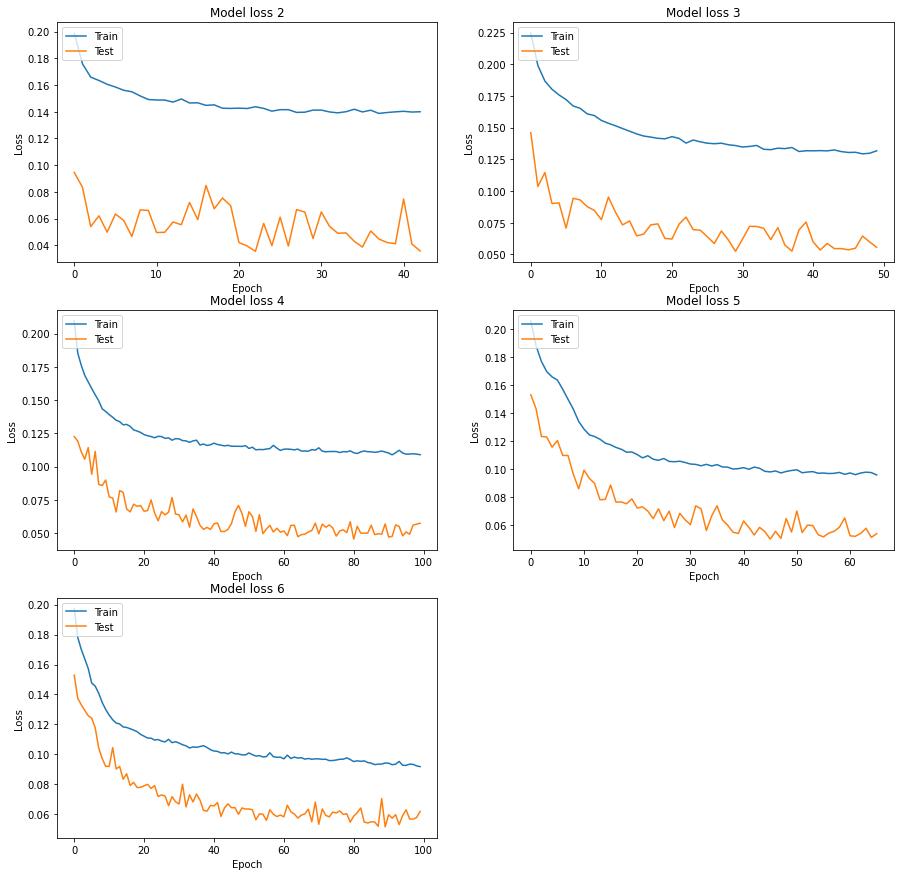

In [16]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')